import independences

In [56]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

 Load and Combine Decade Datasets

In [57]:
csv_files = [
    "dataset-of-60s.csv",
    "dataset-of-70s.csv",
    "dataset-of-80s.csv",
    "dataset-of-90s.csv",
    "dataset-of-00s.csv",
    "dataset-of-10s.csv"
]

dfs = [pd.read_csv(f) for f in csv_files]
df = pd.concat(dfs, ignore_index=True)

print("✅ Combined dataset shape:", df.shape)
display(df.head())


✅ Combined dataset shape: (41106, 19)


,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target
0,Jealous Kind Of Fella,Garland Green,spotify:track:1dtKN6wwlolkM8XZy2y9C1,0.417,0.620,3,-7.727,1,0.0403,0.490,0.000000,0.0779,0.845,185.655,173533,3,32.94975,9,1
1,Initials B.B.,Serge Gainsbourg,spotify:track:5hjsmSnUefdUqzsDogisiX,0.498,0.505,3,-12.475,1,0.0337,0.018,0.107000,0.1760,0.797,101.801,213613,4,48.82510,10,0
2,Melody Twist,Lord Melody,spotify:track:6uk8tI6pwxxdVTNlNOJeJh,0.657,0.649,5,-13.392,1,0.0380,0.846,0.000004,0.1190,0.908,115.940,223960,4,37.22663,12,0
3,Mi Bomba Sonó,Celia Cruz,spotify:track:7aNjMJ05FvUXACPWZ7yJmv,0.590,0.545,7,-12.058,0,0.1040,0.706,0.024600,0.0610,0.967,105.592,157907,4,24.75484,8,0
4,Uravu Solla,P. Susheela,spotify:track:1rQ0clvgkzWr001POOPJWx,0.515,0.765,11,-3.515,0,0.1240,0.857,0.000872,0.2130,0.906,114.617,245600,4,21.79874,14,0


Simulate User Interactions

In [58]:
num_users = 1000  # adjust as needed
num_tracks = df.shape[0]
np.random.seed(42)

# Randomly assign users to tracks
df["user_id"] = np.random.randint(1, num_users + 1, size=num_tracks)

# Simulate plays in last 30 days
df["plays_in_last_30_days"] = np.random.poisson(2, size=num_tracks)

# Simulate average listen duration (fraction of track)
df["avg_listen_duration"] = np.random.uniform(0.3, 1.0, size=num_tracks)

# Replay label: played > 3 times
df["replayed"] = (df["plays_in_last_30_days"] > 3).astype(int)

print("🎯 Replay label distribution:\n", df["replayed"].value_counts())
display(df.head())

🎯 Replay label distribution:
 replayed
0    35155
1     5951
Name: count, dtype: int64


,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,...,tempo,duration_ms,time_signature,chorus_hit,sections,target,user_id,plays_in_last_30_days,avg_listen_duration,replayed
0,Jealous Kind Of Fella,Garland Green,spotify:track:1dtKN6wwlolkM8XZy2y9C1,0.417,0.620,3,-7.727,1,0.0403,0.490,...,185.655,173533,3,32.94975,9,1,103,0,0.552870,0
1,Initials B.B.,Serge Gainsbourg,spotify:track:5hjsmSnUefdUqzsDogisiX,0.498,0.505,3,-12.475,1,0.0337,0.018,...,101.801,213613,4,48.82510,10,0,436,0,0.477540,0
2,Melody Twist,Lord Melody,spotify:track:6uk8tI6pwxxdVTNlNOJeJh,0.657,0.649,5,-13.392,1,0.0380,0.846,...,115.940,223960,4,37.22663,12,0,861,1,0.405390,0
3,Mi Bomba Sonó,Celia Cruz,spotify:track:7aNjMJ05FvUXACPWZ7yJmv,0.590,0.545,7,-12.058,0,0.1040,0.706,...,105.592,157907,4,24.75484,8,0,271,4,0.955715,1
4,Uravu Solla,P. Susheela,spotify:track:1rQ0clvgkzWr001POOPJWx,0.515,0.765,11,-3.515,0,0.1240,0.857,...,114.617,245600,4,21.79874,14,0,107,2,0.402899,0


Feature Engineering

In [59]:
# Select audio features available in your dataset
audio_features = ["danceability", "energy", "valence", "tempo", "acousticness"]

# Compute user-level listening preferences
user_profile = df.groupby("user_id")[audio_features].mean().rename(
    columns=lambda x: f"user_{x}"
)

# Merge user profile back
df = df.merge(user_profile, on="user_id", how="left")

# Difference features (song vs user preference)
df["energy_diff"] = abs(df["energy"] - df["user_energy"])
df["valence_diff"] = abs(df["valence"] - df["user_valence"])
df["danceability_diff"] = abs(df["danceability"] - df["user_danceability"])

# Define features for model
features = audio_features + [
    "user_danceability", "user_energy", "user_valence", "user_tempo", "user_acousticness",
    "energy_diff", "valence_diff", "danceability_diff", "avg_listen_duration"
]

X = df[features]
y = df["replayed"]

print("\n📊 Feature matrix shape:", X.shape)
display(df.head())


📊 Feature matrix shape: (41106, 14)


,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,...,avg_listen_duration,replayed,user_danceability,user_energy,user_valence,user_tempo,user_acousticness,energy_diff,valence_diff,danceability_diff
0,Jealous Kind Of Fella,Garland Green,spotify:track:1dtKN6wwlolkM8XZy2y9C1,0.417,0.620,3,-7.727,1,0.0403,0.490,...,0.552870,0,0.492996,0.622000,0.552763,126.068348,0.391974,0.002000,0.292237,0.075996
1,Initials B.B.,Serge Gainsbourg,spotify:track:5hjsmSnUefdUqzsDogisiX,0.498,0.505,3,-12.475,1,0.0337,0.018,...,0.477540,0,0.554718,0.604036,0.564256,116.858487,0.340997,0.099036,0.232744,0.056718
2,Melody Twist,Lord Melody,spotify:track:6uk8tI6pwxxdVTNlNOJeJh,0.657,0.649,5,-13.392,1,0.0380,0.846,...,0.405390,0,0.559364,0.584718,0.597002,123.839000,0.377678,0.064282,0.310998,0.097636
3,Mi Bomba Sonó,Celia Cruz,spotify:track:7aNjMJ05FvUXACPWZ7yJmv,0.590,0.545,7,-12.058,0,0.1040,0.706,...,0.955715,1,0.528545,0.502311,0.531704,117.416388,0.474659,0.042689,0.435296,0.061455
4,Uravu Solla,P. Susheela,spotify:track:1rQ0clvgkzWr001POOPJWx,0.515,0.765,11,-3.515,0,0.1240,0.857,...,0.402899,0,0.518664,0.586903,0.531249,113.408872,0.347462,0.178097,0.374751,0.003664


 Train Random Forest Classifier


--- Classification Report ---
              precision    recall  f1-score   support

           0       0.86      1.00      0.92      7055
           1       0.00      0.00      0.00      1167

    accuracy                           0.86      8222
   macro avg       0.43      0.50      0.46      8222
weighted avg       0.74      0.86      0.79      8222



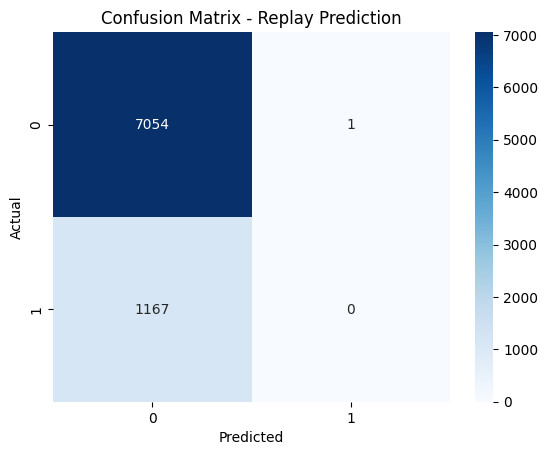

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Train model
model = RandomForestClassifier(n_estimators=150, random_state=42)
model.fit(X_train_scaled, y_train)

# Evaluate
y_pred = model.predict(X_test_scaled)
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Replay Prediction")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Predict Replay Probability for All User–Song Pairs

In [61]:

df["replay_probability"] = model.predict_proba(scaler.transform(X))[:, 1]
print("🎵 Sample predictions:")
display(df[["user_id", "track", "replay_probability", "plays_in_last_30_days"]].head())

🎵 Sample predictions:


,user_id,track,replay_probability,plays_in_last_30_days
0,103,Jealous Kind Of Fella,0.073333,0
1,436,Initials B.B.,0.106667,0
2,861,Melody Twist,0.046667,1
3,271,Mi Bomba Sonó,0.706667,4
4,107,Uravu Solla,0.120000,2


Personalized Song Recommendations

In [62]:


def recommend_songs_for_user(user_id, top_n=5):
    # Tracks already played
    user_songs = df[df["user_id"] == user_id]
    known_tracks = user_songs["track"].unique()

    # Candidate tracks not yet played
    candidates = df[~df["track"].isin(known_tracks)].copy()

    # Attach user's profile
    profile = user_profile.loc[user_id]
    for col in profile.index:
        candidates[col] = profile[col]

    # Difference features
    candidates["energy_diff"] = abs(candidates["energy"] - candidates["user_energy"])
    candidates["valence_diff"] = abs(candidates["valence"] - candidates["user_valence"])
    candidates["danceability_diff"] = abs(candidates["danceability"] - candidates["user_danceability"])

    # Predict replay probability
    Xcand = candidates[features]
    candidates["replay_probability"] = model.predict_proba(scaler.transform(Xcand))[:, 1]

    # Top-N recommendations
    recs = candidates.sort_values("replay_probability", ascending=False).head(top_n)
    return recs[["track", "artist", "replay_probability", "energy", "valence", "danceability"]]

# Example
example_user = 42
recs = recommend_songs_for_user(example_user, top_n=10)
print(f"\n🎧 Personalized Recommendations for User {example_user}")
display(recs)


🎧 Personalized Recommendations for User 42


,track,artist,replay_probability,energy,valence,danceability
25258,Success - Great Expectations Soundtrack,Iggy Pop,0.593333,0.928,0.750,0.371
21812,Luar (A Gente Precisa Ver o Luar),Gilberto Gil,0.553333,0.662,0.952,0.720
27285,True Companion,Marc Cohn,0.533333,0.160,0.293,0.465
33248,Comin' To Your City,Big & Rich,0.520000,0.944,0.660,0.559
7552,Give Everybody Some,The Bar-Kays,0.513333,0.462,0.559,0.671
3522,Brown Shoes Don't Make It,Frank Zappa,0.506667,0.566,0.320,0.280
37931,Risky,DaVido,0.493333,0.702,0.740,0.714
26171,Wasted Time,Skid Row,0.486667,0.881,0.295,0.360
37164,Metal Malóka,Claustrofobia,0.480000,0.998,0.055,0.214
29964,Apparition,Burning Inside,0.480000,0.939,0.394,0.170


Visualize Replay Probability

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127925 (\N{MUSICAL NOTE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


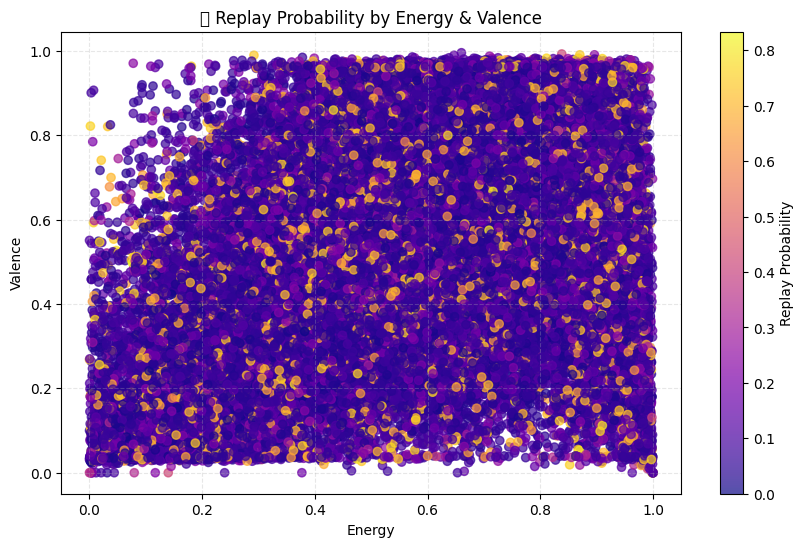

In [63]:


plt.figure(figsize=(10,6))
plt.scatter(df["energy"], df["valence"], c=df["replay_probability"], cmap="plasma", alpha=0.7)
plt.colorbar(label="Replay Probability")
plt.xlabel("Energy")
plt.ylabel("Valence")
plt.title("🎵 Replay Probability by Energy & Valence")
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()






Feature Importance

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127898 (\N{LEVEL SLIDER}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


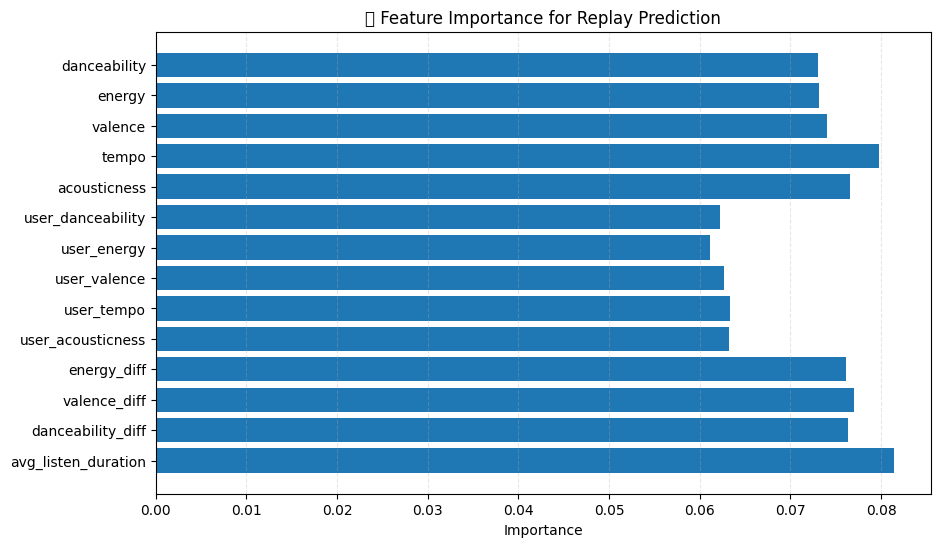

In [64]:
importance = model.feature_importances_
plt.figure(figsize=(10,6))
plt.barh(features, importance)
plt.xlabel("Importance")
plt.title("🎚️ Feature Importance for Replay Prediction")
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.show()

Top 10 Most Played Songs + Song Search

In [65]:
# ====================================================
# 🧠 STEP 9: Top 10 Most Played Songs + Song Search
# ====================================================

def predictive_system(user_id, top_n=10):
    """
    Shows top N most played songs for the user, and allows searching for any song in the dataset.
    """
    print(f"\n🎧 Top {top_n} Most Played Songs for User {user_id} (by plays_in_last_30_days):\n")

    # Get songs already played by the user
    user_songs = df[df["user_id"] == user_id]

    # Sort by plays_in_last_30_days
    top_songs = user_songs.sort_values("plays_in_last_30_days", ascending=False).head(top_n)

    display(top_songs[["track", "artist", "plays_in_last_30_days", "replay_probability"]])

    # Interactive song search
    while True:
        search_song = input("\nEnter a song name to check (or type 'exit' to quit): ").strip()
        if search_song.lower() == "exit":
            print("Exiting search.")
            break

        # Check if the song exists in dataset
        result = df[df["track"].str.contains(search_song, case=False, regex=False)]
        if not result.empty:
            result_display = result[["track", "artist", "plays_in_last_30_days", "replay_probability"]].drop_duplicates()
            print(f"\n🎵 Found {len(result_display)} result(s) for '{search_song}':")
            display(result_display)
        else:
            print(f"❌ '{search_song}' not present in the dataset.")


# ====================================================
# 🧠 STEP 10: Run the Top 10 Most Played Predictive System
# ====================================================
example_user = 42  # change as needed
predictive_system(example_user, top_n=10)



🎧 Top 10 Most Played Songs for User 42 (by plays_in_last_30_days):



,track,artist,plays_in_last_30_days,replay_probability
819,Mi Habana Cuando Te Vuelva A Ver,Miguelito Valdes,7,0.726667
11041,Knoxville Blues,John Fahey,6,0.686667
1436,Baby What Do You Want Me To Do,Barbara Lewis,5,0.646667
36935,Bear Creek Blues,The Carter Family,4,0.653333
10138,Seventh Chakra Keynote B (Violet) - (Bonus Ver...,Steven Halpern,3,0.066667
15783,Roda Viva - Ao Vivo,MPB4,3,0.066667
1923,You're The Reason I'm Living,Bobby Darin,3,0.060000
26458,Bongo Bop,Charlie Parker,3,0.040000
23346,Monster Jam,Spoonie Gee Meets The Sequence,3,0.046667
22618,How Can You Love Me,Ambrosia,3,0.086667



Enter a song name to check (or type 'exit' to quit): dark

🎵 Found 80 result(s) for 'dark':


,track,artist,plays_in_last_30_days,replay_probability
5458,The Dark End Of The Street,James Carr,2,0.086667
5605,Darkest Street In Town,Jimmy Clanton,0,0.120000
5814,Dark As a Dungeon,Harry Belafonte,2,0.073333
7433,Bohemia After Dark,Georges Arvanitas,4,0.680000
8801,Dark Eye Tango,Al Di Meola,1,0.100000
...,...,...,...,...
40300,Life in Darkness,Helllight,0,0.066667
40484,Slow Dancing In The Dark,Joji,0,0.033333
40517,Dark Roots of Earth - Live @ Paramount Theatre...,Testament,1,0.080000
41021,Darkside,Kastle,2,0.100000



Enter a song name to check (or type 'exit' to quit): exit
Exiting search.


Save the Trained Model and Scaler

In [66]:

import pickle

model_filename = "music_recommendation_prediction_model.sav"
scaler_filename = "replay_scaler.sav"

pickle.dump(model, open(model_filename, "wb"))
pickle.dump(scaler, open(scaler_filename, "wb"))

print("✅ Model and Scaler saved successfully!")

✅ Model and Scaler saved successfully!


Load the Saved Model and Scaler

In [67]:
# ====================================================
# 🔁 STEP 12: Load the Saved Model and Scaler (Corrected)
# ====================================================
import pickle
import os

model_filename = "music_recommendation_prediction_model.sav"
scaler_filename = "replay_scaler.sav"

if os.path.exists(model_filename) and os.path.exists(scaler_filename):
    loaded_model = pickle.load(open(model_filename, "rb"))
    loaded_scaler = pickle.load(open(scaler_filename, "rb"))
    print("✅ Model and Scaler loaded successfully!")

    # Verify by predicting again (optional)
    sample_features = X_test.iloc[:5]
    sample_scaled = loaded_scaler.transform(sample_features)
    pred_probs = loaded_model.predict_proba(sample_scaled)[:, 1]
    print("\n🎵 Sample Replay Probabilities (from loaded model):")
    print(pred_probs)
else:
    print("❌ Model or Scaler file not found! Please check filenames or rerun the save step.")


✅ Model and Scaler loaded successfully!

🎵 Sample Replay Probabilities (from loaded model):
[0.31333333 0.15333333 0.17333333 0.12666667 0.21333333]
